In [17]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Utils

In [3]:
def get_fashion_MNIST_data():
  (Xtrain, Ytrain), (Xtest, Ytest) = tf.keras.datasets.fashion_mnist.load_data()
  Xtrain, Xtest = Xtrain / 255.0, Xtest / 255.0
  Xtrain = np.expand_dims(Xtrain, -1)
  Xtest = np.expand_dims(Xtest, -1)
  w, h, c = Xtrain[0].shape
  n_classes = len(set(Ytrain))
  
  # Label mapping
  label_map = '''T-shirt/top
  Trouser
  Pullover
  Dress
  Coat
  Sandal
  Shirt
  Sneaker
  Bag
  Ankle boot'''.split("\n")
  return Xtrain, Ytrain, Xtest, Ytest, n_classes, (w, h, c), label_map

def get_CIFAR_10_data():
  (Xtrain, Ytrain), (Xtest, Ytest) = tf.keras.datasets.cifar10.load_data()
  Xtrain, Xtest = Xtrain / 255.0, Xtest / 255.0
  Ytrain = Ytrain.flatten()
  Ytest = Ytest.flatten()
  w, h, c = Xtrain[0].shape
  n_classes = len(set(Ytrain))

  label_map = '''airplane
  automobile
  bird
  cat
  deer
  dog
  frog
  horse
  ship
  truck'''.split()
  return Xtrain, Ytrain, Xtest, Ytest, n_classes, (w, h, c), label_map

In [4]:
# Plot confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


# Plot misclassified images
import pandas as pd

def plot_misclasified_examples(x, true_lables, predicted_lables, n=5, print_misclassified=False, labels=None):
  misclassified_idx = np.where(predicted_lables != true_lables)[0]
  misclassified_random_idxes = np.random.choice(misclassified_idx, n*n)
  plt.figure(figsize=(15,15))
  for i in range(n*n):
      idx = misclassified_random_idxes[i]
      plt.subplot(n,n,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(x[idx], cmap='gray')
      if labels==None:
        plt.xlabel("True  %s, Pred: %s" % (true_lables[idx], predicted_lables[idx]))
      else:
        plt.xlabel("True  %s, Pred: %s" % (labels[true_lables[idx]], labels[predicted_lables[idx]]))
  plt.show()

  if print_misclassified:
      if labels==None:
        print(pd.DataFrame({'idx':misclassified_random_idxes,
                        'true':true_lables[misclassified_random_idxes],
                        'pred':predicted_lables[misclassified_random_idxes]}))
      else:
        print(pd.DataFrame({'idx':misclassified_random_idxes,
                        #'true':labels[true_lables[misclassified_random_idxes]],
                        'true':true_lables[misclassified_random_idxes],
                        #'pred':labels[predicted_lables[misclassified_random_idxes]]}))
                        'pred':predicted_lables[misclassified_random_idxes]}))

def plot_examples(x, y, cmap, labels=None):
  plt.figure(figsize=(15,15))
  for i in range(25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(x[i], cmap=cmap)
      if labels==None:
        plt.xlabel(y[i])
      else:
        plt.xlabel(labels[y[i]])
  plt.show()

def report(history, y_test, y_hat):
  plt.plot(history['loss'], label='loss')
  plt.plot(history['val_loss'], label='val_loss')
  plt.legend()
  plt.show()

  plt.plot(history['accuracy'], label='accuracy')
  plt.plot(history['val_accuracy'], label='val_accuracy')
  plt.legend()
  plt.show()

  cm = confusion_matrix(y_test, y_hat)
  plot_confusion_matrix(cm, list(range(10)))

# Build simple model

In [5]:
# model for MNIST

def get_simple_model(sample_shape, n_classes):
  i = Input(shape=sample_shape)
  x = Conv2D(32, kernel_size=(3, 3), strides=2, activation='relu')(i)
  x = Conv2D(64, kernel_size=(3, 3), strides=2, activation='relu')(x)
  x = Conv2D(128, kernel_size=(3, 3), strides=2, activation='relu')(x)
  x = Flatten()(x)
  x = Dropout(0.2)(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(n_classes, activation='softmax')(x)

  model = Model(i ,x)
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  model.summary()
  return model

In [16]:
# models for CIFAR-10

def get_simple_cifar_10_model(sample_shape, n_classes):
  i = Input(shape=sample_shape)
  x = Conv2D(32, kernel_size=(3, 3), strides=2, activation='relu')(i)
  x = Conv2D(64, kernel_size=(3, 3), strides=2, activation='relu')(x)
  x = Conv2D(128, kernel_size=(3, 3), strides=2, activation='relu')(x)
  x = Flatten()(x)
  x = Dropout(0.2)(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(n_classes, activation='softmax')(x)

  model = Model(i ,x)
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  model.summary()
  return model

def get_better_cifar_10_model(sample_shape, n_classes):
  i = Input(shape=sample_shape)

  x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
  x = BatchNormalization()(x)
  x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((2, 2))(x)

  x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((2, 2))(x)

  x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D((2, 2))(x)

  x = Flatten()(x)
  x = Dropout(0.2)(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(n_classes, activation='softmax')(x)

  model = Model(i ,x)
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  model.summary()
  return model

# Train model and predict for fashion MNIST

4431872/4422102 [==============================] - 0s 0us/step
Xtrain.shape: (60000, 28, 28, 1)
Ytrain.shape: (60000,)
Number of test data: 10000
Number classes: 10


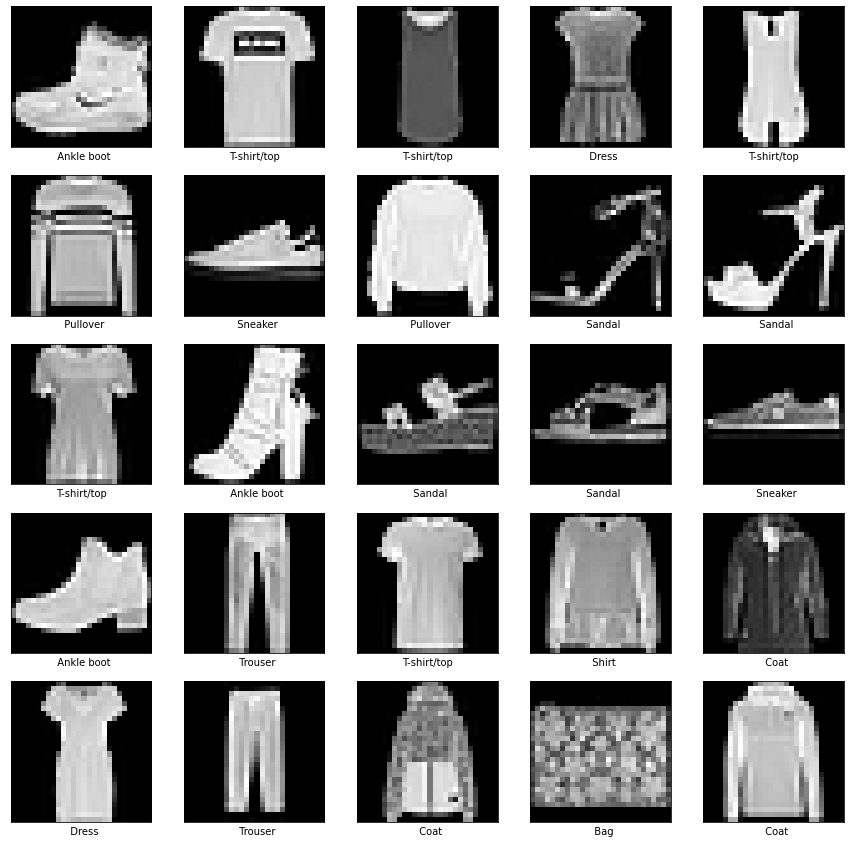

In [7]:
Xtrain, Ytrain, Xtest, Ytest, K, sample_shape, label_map = get_fashion_MNIST_data()
print('Xtrain.shape:', Xtrain.shape)
print('Ytrain.shape:', Ytrain.shape)
print('Number of test data:', len(Xtest))
print('Number classes:', K)

plot_examples(Xtrain.reshape((len(Xtrain), sample_shape[0], sample_shape[1])), Ytrain, cmap='gray', labels=label_map)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 13, 13, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656

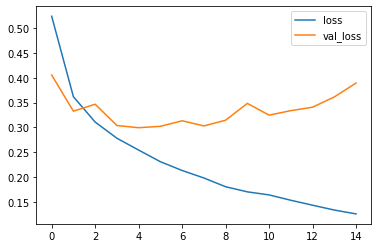

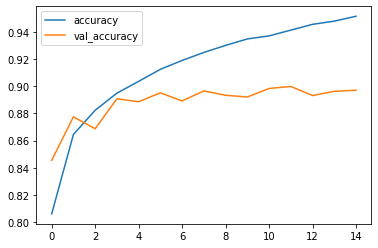

Confusion matrix, without normalization
[[876   0  16  19   3   2  75   0   9   0]
 [  4 973   0  15   3   0   4   0   1   0]
 [ 23   1 864   9  50   0  51   0   2   0]
 [ 21   3  12 911  26   1  20   0   6   0]
 [  1   0  58  33 840   0  66   0   2   0]
 [  1   0   0   0   0 984   0   6   1   8]
 [133   3  67  24 115   1 649   0   8   0]
 [  0   0   0   0   0  29   0 943   2  26]
 [  4   0   3   1   4   1   7   3 976   1]
 [  1   0   0   0   0   8   0  35   1 955]]


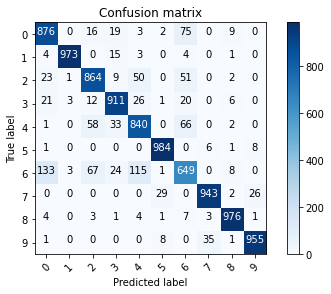

In [8]:
mnist_model = get_simple_model(sample_shape=sample_shape, n_classes=K)
history = mnist_model.fit(Xtrain, Ytrain, validation_data=(Xtest, Ytest), epochs=15)

y_hat = mnist_model.predict(Xtest).argmax(axis=1)
report(history.history, Ytest, y_hat)

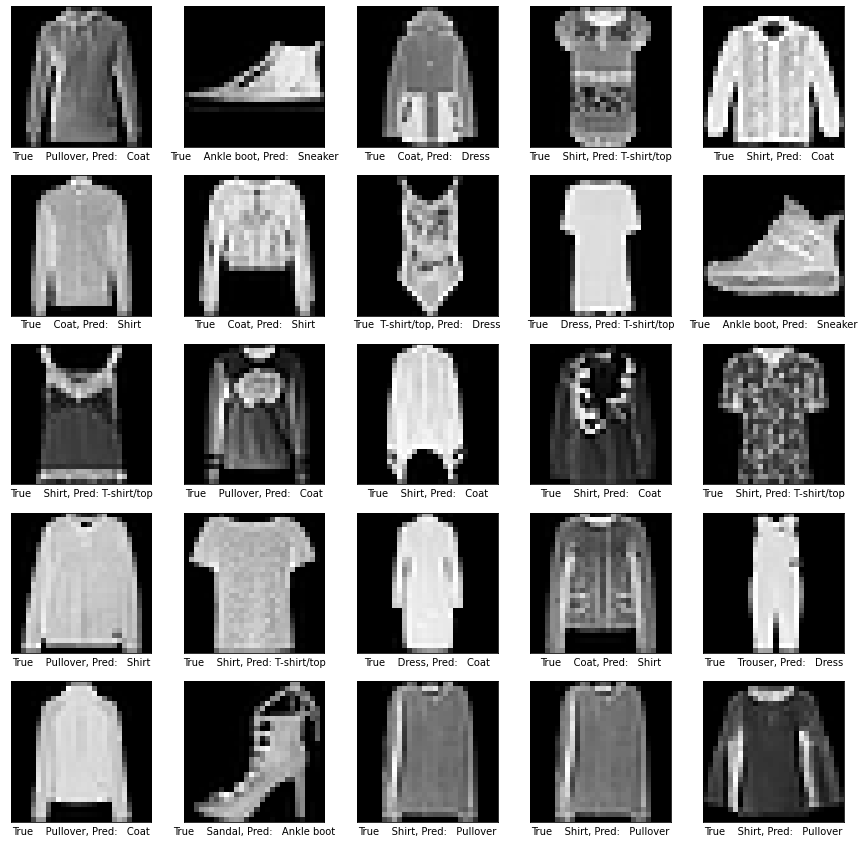

     idx  true  pred
0   6567     2     4
1    441     9     7
2   3304     4     3
3   4109     6     0
4   7130     6     4
5   1856     4     6
6   8958     4     6
7   2997     0     3
8   8884     3     0
9   6163     9     7
10  5566     6     0
11  6221     2     4
12  3338     6     4
13  5589     6     4
14  4692     6     0
15  8051     2     6
16  5186     6     0
17  5971     3     4
18  7314     4     6
19  9244     1     3
20  5474     2     4
21  4742     5     9
22  3864     6     2
23  3864     6     2
24  2326     6     2


In [9]:
plot_misclasified_examples(Xtest.reshape(Xtest.shape[:-1]), Ytest, y_hat, print_misclassified=True, labels=label_map)

# Train model and predict for fashion CIFAR-10

170508288/170498071 [==============================] - 6s 0us/step
Xtrain.shape: (50000, 32, 32, 3)
Ytrain.shape: (50000,)
Number of test data: 10000
Number classes: 10


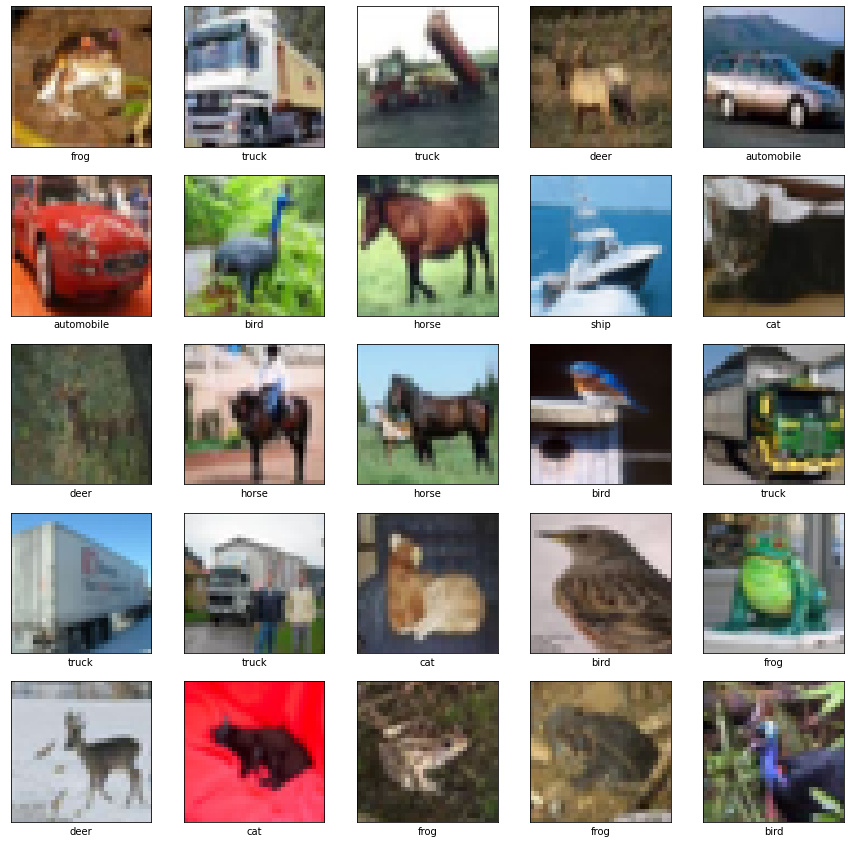

In [10]:
Xtrain, Ytrain, Xtest, Ytest, K, sample_shape, label_map = get_CIFAR_10_data()
print('Xtrain.shape:', Xtrain.shape)
print('Ytrain.shape:', Ytrain.shape)
print('Number of test data:', len(Xtest))
print('Number classes:', K)

plot_examples(Xtrain, Ytrain, cmap='gray', labels=label_map)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 15, 15, 32)        896       
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 flatten_1 (Flatten)         (None, 1152)              0         
                                                                 
 dropout_2 (Dropout)         (None, 1152)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)              1180

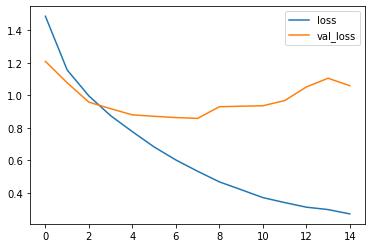

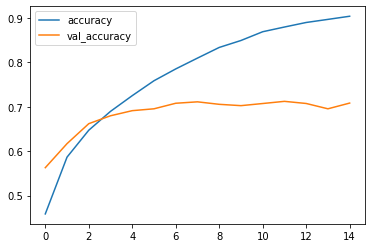

Confusion matrix, without normalization
[[755  16  50  22  26   9  15  19  51  37]
 [ 23 813  12  10   4   9  14   2  25  88]
 [ 60   5 605  59  94  64  57  35  14   7]
 [ 18   7  71 530  69 180  66  37  11  11]
 [ 18   3  74  59 655  43  62  76   8   2]
 [ 11   3  52 197  52 598  26  55   4   2]
 [  4   9  38  55  40  38 800  10   6   0]
 [ 11   3  34  42  52  71  12 768   0   7]
 [ 71  38  13  17  12  13   6   6 794  30]
 [ 31  72  15  29   4  17  10  30  26 766]]


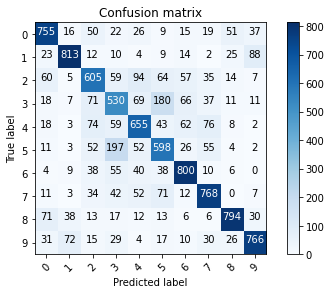

In [11]:
cifar10_model = get_simple_cifar_10_model(sample_shape=sample_shape, n_classes=K)
history = cifar10_model.fit(Xtrain, Ytrain, validation_data=(Xtest, Ytest), epochs=15)

y_hat = cifar10_model.predict(Xtest).argmax(axis=1)
report(history.history, Ytest, y_hat)

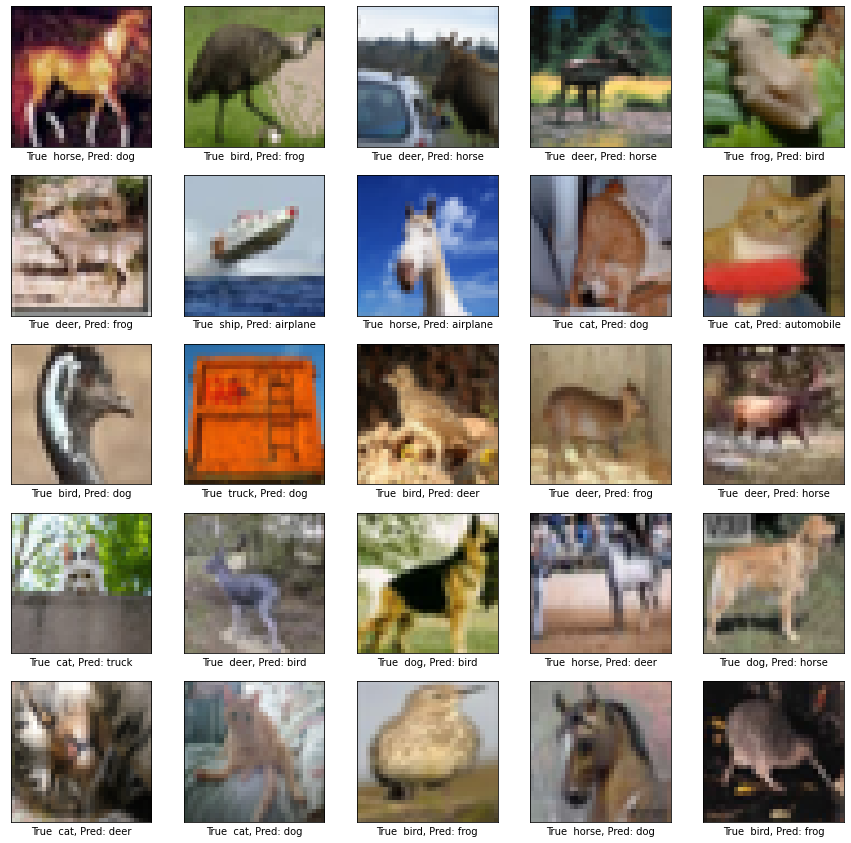

     idx  true  pred
0   4924     7     5
1   2852     2     6
2   8058     4     7
3   2069     4     7
4   3785     6     2
5   7571     4     6
6   6141     8     0
7   2325     7     0
8   5191     3     5
9    573     3     1
10  2742     2     5
11  2756     9     5
12  9982     2     4
13  4029     4     6
14  5983     4     7
15  1346     3     9
16  6446     4     2
17  9616     5     2
18  2816     7     4
19  8301     5     7
20   224     3     4
21  2422     3     5
22  2977     2     6
23   210     7     5
24  8542     2     6


In [12]:
plot_misclasified_examples(Xtest, Ytest, y_hat, print_misclassified=True, labels=label_map)

# Data augmentation utils

In [14]:
# make sure to use GPU

print(tf.test.gpu_device_name())
assert tf.test.gpu_device_name() == '/device:GPU:0'

/device:GPU:0


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0   

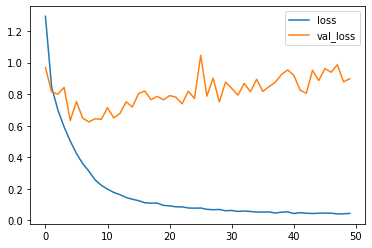

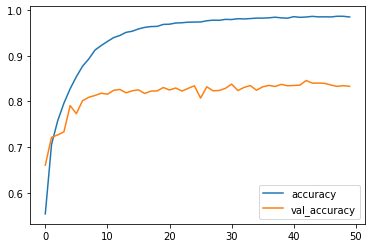

Confusion matrix, without normalization
[[755  16  50  22  26   9  15  19  51  37]
 [ 23 813  12  10   4   9  14   2  25  88]
 [ 60   5 605  59  94  64  57  35  14   7]
 [ 18   7  71 530  69 180  66  37  11  11]
 [ 18   3  74  59 655  43  62  76   8   2]
 [ 11   3  52 197  52 598  26  55   4   2]
 [  4   9  38  55  40  38 800  10   6   0]
 [ 11   3  34  42  52  71  12 768   0   7]
 [ 71  38  13  17  12  13   6   6 794  30]
 [ 31  72  15  29   4  17  10  30  26 766]]


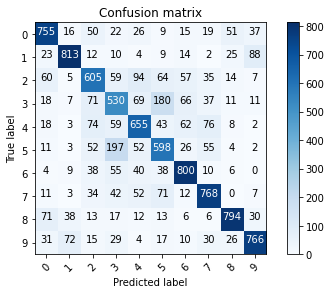

In [20]:
# pretrain model on oryginal data, without data augmentation

cifar10_better_model = get_better_cifar_10_model(sample_shape=sample_shape, n_classes=K)
history = cifar10_better_model.fit(Xtrain, Ytrain, validation_data=(Xtest, Ytest), epochs=50)

y_hat = cifar10_model.predict(Xtest).argmax(axis=1)
report(history.history, Ytest, y_hat)

## train furter with augmented data

In [21]:
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
batch_size = 32
steps_per_epoch=Xtrain.shape[0] // batch_size
train_generator = data_generator.flow(Xtrain, Ytrain, batch_size)

Epoch 1/50
1562/1562 [==============================] - 32s 20ms/step - loss: 0.5516 - accuracy: 0.8249 - val_loss: 0.5148 - val_accuracy: 0.8363
Epoch 2/50
1562/1562 [==============================] - 32s 21ms/step - loss: 0.4418 - accuracy: 0.8535 - val_loss: 0.4722 - val_accuracy: 0.8453
Epoch 3/50
1562/1562 [==============================] - 32s 20ms/step - loss: 0.4165 - accuracy: 0.8618 - val_loss: 0.4526 - val_accuracy: 0.8516
Epoch 4/50
1562/1562 [==============================] - 32s 21ms/step - loss: 0.3953 - accuracy: 0.8668 - val_loss: 0.4371 - val_accuracy: 0.8548
Epoch 5/50
1562/1562 [==============================] - 31s 20ms/step - loss: 0.3762 - accuracy: 0.8743 - val_loss: 0.4452 - val_accuracy: 0.8584
Epoch 6/50
1562/1562 [==============================] - 31s 20ms/step - loss: 0.3635 - accuracy: 0.8779 - val_loss: 0.4432 - val_accuracy: 0.8563
Epoch 7/50
1562/1562 [==============================] - 33s 21ms/step - loss: 0.3445 - accuracy: 0.8843 - val_loss: 0.4420 -

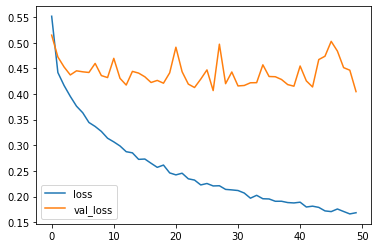

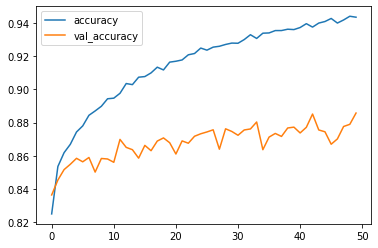

Confusion matrix, without normalization
[[870   6  31  15  14   4   6   4  20  30]
 [  7 954   0   1   1   0   1   0   3  33]
 [ 15   0 835  41  37  28  26   7   4   7]
 [  8   3  29 777  28  94  27  17   2  15]
 [  6   1  23  35 877  17  17  19   1   4]
 [  4   2  14  87  20 841  11  14   0   7]
 [  4   1  20  37  10   8 917   0   2   1]
 [  6   0   9  13  25  14   2 924   0   7]
 [ 30   8   4   6   1   3   2   0 912  34]
 [  5  36   0   2   0   1   2   0   4 950]]


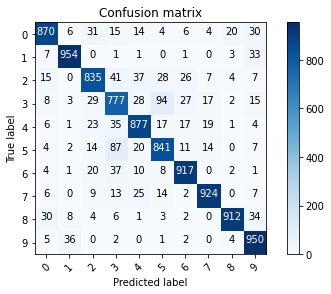

In [22]:
history = cifar10_better_model.fit(train_generator, validation_data=(Xtest, Ytest), steps_per_epoch=steps_per_epoch, epochs=50)

y_hat = cifar10_better_model.predict(Xtest).argmax(axis=1)
report(history.history, Ytest, y_hat)

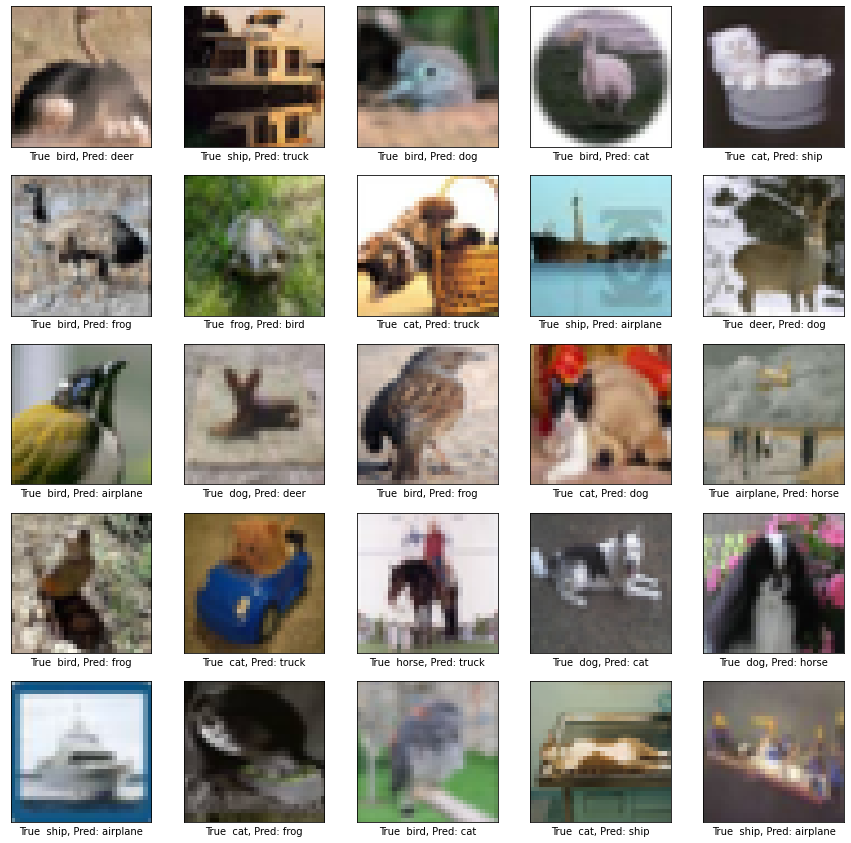

     idx  true  pred
0   3887     2     4
1   4865     8     9
2   1756     2     5
3   6533     2     3
4   9812     3     8
5   4732     2     6
6   4066     6     2
7   6912     3     9
8   4347     8     0
9   8003     4     5
10  9965     2     0
11  3192     5     4
12  7947     2     6
13  7549     3     5
14  3550     0     7
15  9039     2     6
16  6859     3     9
17  5234     7     9
18  3574     5     3
19    42     5     7
20   875     8     0
21  3113     3     6
22  7802     2     3
23  4754     3     8
24  5398     8     0


In [23]:
plot_misclasified_examples(Xtest, Ytest, y_hat, print_misclassified=True, labels=label_map)